In [1]:
# .py file auto-generated from the .ipynb file
import duckdb
import traceback
import logging
import os
from pathlib import Path
from tqdm.auto import tqdm

duckdb.execute("SET enable_progress_bar = true;")
duckdb.execute("SET progress_bar_time = 200;")
duckdb.execute("SET temp_directory = 'temp.tmp';")

# Set up a logger to show some timing info
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s %(message)s", datefmt="%H:%M:%S"
)


def is_in_notebook():
    # https://stackoverflow.com/a/67622408
    rstk = traceback.extract_stack(limit=1)[0]
    return rstk[0].startswith("<ipython")

In [2]:
if is_in_notebook():
    ! jupyter nbconvert --to script --no-prompt process_peaks.ipynb

[NbConvertApp] Converting notebook process_peaks.ipynb to script
[NbConvertApp] Writing 24063 bytes to process_peaks.py


In [3]:
# This notebook compiles itself to a python script.
# the meant usage is to run it with a subset of the data
# and then commit the file for use on cloud training.

if is_in_notebook():
    PATH_PREFIX = "../prospect_data"
    con = duckdb.connect("prospect_dev.ddb")
else:
    import logging
    from fsspec import filesystem

    # this line will throw an exception if the appropriate filesystem interface is not installed
    duckdb.register_filesystem(filesystem("gcs"))
    logging.info("Running in cloud environment!!!!")
    con = duckdb.connect("prospect_prod.ddb")
    PATH_PREFIX = "gs://jspp_prospect_mirror"
    PATH_PREFIX = f"{os.environ['HOME']}/mount-folder/jspp_prospect_mirror/"

METADATA_FILES = f"{PATH_PREFIX}/*meta_data.parquet"
ANNOTATION_FILES = f"{PATH_PREFIX}/*annotation.parquet"
globbed_annotation_files = list(Path(PATH_PREFIX).rglob("*annotation.parquet"))

if len(globbed_annotation_files) == 0:
    raise ValueError("No annotation files found!")

In [4]:
if is_in_notebook():
    print(con.sql(f"SELECT * FROM parquet_scan('{METADATA_FILES}') LIMIT 5").to_df())

                                      raw_file  scan_number  \
0  01812a_GA3-TUM_third_pool_1_01_01-DDA-1h-R1        34341   
1  01812a_GA3-TUM_third_pool_1_01_01-DDA-1h-R1        39787   
2  01812a_GA3-TUM_third_pool_1_01_01-DDA-1h-R1        23850   
3  01812a_GA3-TUM_third_pool_1_01_01-DDA-1h-R1         5398   
4  01812a_GA3-TUM_third_pool_1_01_01-DDA-1h-R1        26459   

                                   modified_sequence  precursor_charge  \
0                                        DNYDQLVRIAK                 2   
1                                        MDLESQISDMR                 2   
2                                         QLQQIERQLK                 2   
3  PC[UNIMOD:4]C[UNIMOD:4]C[UNIMOD:4]QTTC[UNIMOD:...                 2   
4                                        LNTEVTTWRTK                 2   

   precursor_intensity         mz  precursor_mz fragmentation mass_analyzer  \
0          141925100.0  667.85678    667.854794           HCD          FTMS   
1           637602

In [5]:
if is_in_notebook():
    print("Couns of metadata files by fragmentation and mass analyzer")
    print(
        con.sql(
            "SELECT COUNT(*), internal.fragmentation, internal.mass_analyzer "
            f"FROM (SELECT * FROM parquet_scan('{METADATA_FILES}')) AS internal "
            "GROUP BY internal.fragmentation, internal.mass_analyzer"
        ).to_df()
    )

    print("\n\n\n\n")
    print("Counts of unique neutral losses")
    print(
        con.sql(
            "SELECT COUNT(*), internal.neutral_loss "
            f"FROM (SELECT * FROM parquet_scan('{ANNOTATION_FILES}')) AS internal "
            "GROUP BY internal.neutral_loss "
            "ORDER BY COUNT(*) DESC "
        ).to_df()
    )

Couns of metadata files by fragmentation and mass analyzer
   count_star() fragmentation mass_analyzer
0        237482           HCD          FTMS
1         59400           CID          ITMS
2         41852           HCD          ITMS





Counts of unique neutral losses
     count_star()   neutral_loss
0         8073708               
1         3692080            H2O
2         3111499            NH3
3         1777602        H2O-H2O
4         1761081        H2O-NH3
..            ...            ...
346         25457  C3H6SO-C3H6SO
347         25335   C3H6SO-CH4SO
348         17860    C8H7N-C8H7N
349         17192    C8H7N-C9H9N
350         16738    C9H9N-C9H9N

[351 rows x 2 columns]


In [6]:
if is_in_notebook():
    print(con.sql(f"SELECT * FROM parquet_scan('{ANNOTATION_FILES}') LIMIT 5").to_df())

  ion_type  no  charge  experimental_mass  theoretical_mass  intensity  \
0        y   3       1          302.22772        302.134661       0.02   
1        y   6       2          302.22772        302.140278       0.02   
2        b   3       1          302.22772        302.149919       0.02   
3        y   5       2          302.22772        302.686864       0.02   
4        y   3       1          320.32074        320.145226       0.05   

  neutral_loss  fragment_score    peptide_sequence  scan_number  \
0    C2H5N-H2O              65  AFTFDDEDDELSQLKESK        34380   
1  C4H11N-C4H8              39  AFTFDDEDDELSQLKESK        34380   
2          H2O              95  AFTFDDEDDELSQLKESK        34380   
3                           99  AFTFDDEDDELSQLKESK        34380   
4        C2H5N              70  AFTFDDEDDELSQLKESK        34380   

                                      raw_file  
0  01829a_GA3-TUM_third_pool_3_01_01-DDA-1h-R1  
1  01829a_GA3-TUM_third_pool_3_01_01-DDA-1h-R1  
2  01

In [7]:
logging.info("Defining types")
try:
    con.execute(
        """
        CREATE TYPE ion_type_type AS ENUM ('a', 'b', 'c', 'x', 'y', 'z');
        CREATE TYPE fragmentation_type AS ENUM ('HCD', 'CID', 'ETD');
        CREATE TYPE mass_analyzer_type AS ENUM ('ITMS', 'FTMS');
        """
    )
except duckdb.CatalogException:
    logging.info("Types already defined")
logging.info("Done defining types")

02:11:14 Defining types
02:11:14 Types already defined
02:11:14 Done defining types


In [8]:
logging.info("Creating annotation table")
query = f"""
CREATE OR REPLACE TABLE rt_qc AS
SELECT
    modified_sequence,
    MEDIAN(retention_time) as retention_time_m,
    MEDIAN(indexed_retention_time) as irt_m,
    QUANTILE_CONT(retention_time, 0.25) as retention_time_q25,
    QUANTILE_CONT(retention_time, 0.75) as retention_time_q75,
    QUANTILE_CONT(indexed_retention_time, 0.25) as irt_q25,
    QUANTILE_CONT(indexed_retention_time, 0.75) as irt_q75,
    COUNT(*) as n
FROM
(
    SELECT modified_sequence, andromeda_score, retention_time, indexed_retention_time,
    FROM
    (
        SELECT 
            modified_sequence,
            andromeda_score,
            retention_time,
            indexed_retention_time,
            row_number() OVER (
                PARTITION BY modified_sequence, fragmentation, mass_analyzer
                ORDER BY andromeda_score DESC
            ) AS scan_rank
        FROM "{METADATA_FILES}"
    ) FILER WHERE scan_rank <= 20            -- take top 20 scans
)
GROUP BY modified_sequence
HAVING n >= 5 AND irt_q75 - irt_q25 < 10    -- require at least 5 scans and irt range < 10
"""

con.sql(query)
logging.info("Created annotation table")

# Create indices
logging.info("Creating indices")
con.sql("CREATE INDEX modseq_idx ON rt_qc(modified_sequence)")
logging.info("Created indices")

glimpse = con.sql("SELECT * FROM rt_qc LIMIT 5")
if is_in_notebook():
    print(glimpse.to_df())

02:11:14 Creating annotation table
02:11:14 Created annotation table
02:11:14 Creating indices
02:11:14 Created indices


                       modified_sequence  retention_time_m      irt_m  \
0           AAMTELKSC[UNIMOD:4]IDGLQPMHK           36.2015  57.693195   
1  AASTMSIC[UNIMOD:4]SSAC[UNIMOD:4]TDSWR           35.1565  54.356210   
2                            AAVILPKDASR           24.5830  26.029358   
3                             AEEIALLIQR           44.1290  77.122522   
4                 AEVPC[UNIMOD:4]AAAEGGR           19.7990  15.412914   

   retention_time_q25  retention_time_q75    irt_q25    irt_q75   n  
0            36.10225            36.30150  57.476155  57.912169   6  
1            35.05425            35.26000  53.168757  54.618800   8  
2            24.48875            24.68025  25.803770  26.288185  60  
3            43.95750            44.62650  76.683853  78.274021  59  
4            19.71400            19.97800  15.225750  15.811174  47  


In [9]:
logging.info("Creating filtered metadata table")
con.sql(
    f"""
    CREATE OR REPLACE TABLE filtered_meta AS
    SELECT
        raw_file,
        scan_number,
        modified_sequence,
        CAST (precursor_charge AS TINYINT) AS precursor_charge,
        precursor_intensity,
        mz,
        precursor_mz,
        CAST (fragmentation AS fragmentation_type) AS fragmentation,
        CAST (mass_analyzer AS mass_analyzer_type) AS mass_analyzer,
        retention_time,
        indexed_retention_time,
        orig_collision_energy,
        CAST (peptide_length AS TINYINT) AS peptide_length,
        aligned_collision_energy,
        retention_time_m,
        irt_m
    FROM (
        SELECT *,
        row_number() OVER (
                        PARTITION BY
                            "{METADATA_FILES}".modified_sequence,
                            "{METADATA_FILES}".precursor_charge,
                            "{METADATA_FILES}".fragmentation,
                            "{METADATA_FILES}".mass_analyzer,
                            "{METADATA_FILES}".orig_collision_energy
                        ORDER BY ABS("{METADATA_FILES}".retention_time - rt_qc.retention_time_m) ASC
                    ) AS rt_diff_rank
        FROM "{METADATA_FILES}" 
        JOIN rt_qc ON ("{METADATA_FILES}".modified_sequence = rt_qc.modified_sequence)
        WHERE retention_time <= retention_time_q75 AND retention_time >= retention_time_q25
    )
    WHERE rt_diff_rank <= 10 AND peptide_length < 35
    """
)
logging.info("Created filtered metadata table")

glimpse = con.sql("SELECT * FROM filtered_meta LIMIT 5")
count = con.sql("SELECT COUNT(*) FROM filtered_meta")

logging.info(f"Filtered metadata table has {count.to_df().iloc[0,0]} rows")
glimpse.to_df()

02:11:14 Creating filtered metadata table
02:11:14 Created filtered metadata table
02:11:14 Filtered metadata table has 131664 rows


,raw_file,scan_number,modified_sequence,precursor_charge,precursor_intensity,mz,precursor_mz,fragmentation,mass_analyzer,retention_time,indexed_retention_time,orig_collision_energy,peptide_length,aligned_collision_energy,retention_time_m,irt_m
0,01812a_GA3-TUM_third_pool_1_01_01-3xHCD-1h-R1,17003,AAAHGQWELQR,3,9704263.0,422.88278,422.882597,HCD,FTMS,24.130,26.572649,25.0,11,27.161428,24.140,26.301474
1,01812a_GA3-TUM_third_pool_1_01_01-3xHCD-1h-R1,16933,AAAHGQWELQR,3,24447170.0,422.88278,422.882697,HCD,FTMS,24.071,26.423535,25.0,11,27.161428,24.140,26.301474
2,01812a_GB3-TUM_third_pool_2_01_01-2xIT_2xHCD-1...,14720,AAAHGQWELQRVHAK,4,35617570.0,426.22876,426.228603,CID,ITMS,20.679,17.735715,35.0,15,35.000000,20.646,17.541545
3,01829a_BA3-TUM_third_pool_3_01_01-3xHCD-1h-R1,29402,AALLGRHC[UNIMOD:4]PLC[UNIMOD:4]VPAGEVFSQK,4,13239330.0,578.30160,578.301504,HCD,FTMS,37.908,62.056720,25.0,21,27.091641,37.890,61.975037
4,01829a_BA3-TUM_third_pool_3_01_01-3xHCD-1h-R1,29353,AALLGRHC[UNIMOD:4]PLC[UNIMOD:4]VPAGEVFSQK,4,24553030.0,578.30160,578.301604,HCD,FTMS,37.866,61.950180,25.0,21,27.091641,37.890,61.975037


In [10]:
# Create indices
logging.info("Creating indices")
con.sql(
    "DROP INDEX IF EXISTS modseq_fmeta_idx ; CREATE INDEX modseq_fmeta_idx ON filtered_meta(modified_sequence)"
)
logging.info("Created indices")

02:11:14 Creating indices
02:11:14 Created indices


In [11]:
if is_in_notebook():
    con.sql(
        f"""
            SELECT
                raw_file,
                scan_number,
                peptide_sequence,
                CAST (ion_type as ion_type_type) AS ion_type,
                CAST (no AS TINYINT) AS no,
                CAST (charge AS TINYINT) AS charge,
                intensity,
                experimental_mass,
                theoretical_mass,
                fragment_score,
            FROM "{ANNOTATION_FILES}"
            WHERE neutral_loss = '' AND scan_number = 44454 AND ion_type = 'y' AND no = 3 AND charge = 2 AND peptide_sequence LIKE 'SHYVAQTGILWLLM%'
            GROUP BY raw_file, scan_number, peptide_sequence, ion_type, no, charge, intensity, experimental_mass, theoretical_mass, fragment_score
        """
    ).to_df()

    # Note how multiple peaks can match a single fragment if there is ambiguity in the annotation
    # This seems to happen in very rare cases and it cannot be solved by the fragment score.

    # Just to get it over with I will use the max intensity one.

    # I am using here a cherry-picked example that popped up during my qc of the data
    # after the aggregation.

In [12]:
# NOTE!!! Here there isn un-handled ambiguity in the annotation. ...
# there can be multiple peaks that match a single ion type, no, charge, and sequence.

logging.info("Creating local annotation table")


# Create the table with the first file
first_annot_file = str(globbed_annotation_files[0])
logging.info(f"Creating local annotation table from {first_annot_file}")

# read_parquet('test.parq')

con.sql(
    f"""
        CREATE OR REPLACE TABLE tmp AS SELECT
            raw_file,
            scan_number,
            peptide_sequence,
            CAST (ion_type as ion_type_type) AS ion_type,
            CAST (no AS TINYINT) AS fragment_no,
            CAST (charge AS TINYINT) AS charge,
            neutral_loss,
            intensity,
            theoretical_mass as theoretical_fragment_mz,
            fragment_score,
        FROM read_parquet('{first_annot_file}', filename = false)
        WHERE neutral_loss = '' AND fragment_score > 0.5 AND ion_type IN ('a', 'b', 'c', 'x', 'y', 'z');
        """
)

out = con.sql(
    f"""
        EXPLAIN ANALYZE
        CREATE OR REPLACE TABLE local_annotations AS
        SELECT
            filtered_meta.raw_file as raw_file,
            filtered_meta.scan_number as scan_number,
            peptide_sequence,
            CAST (precursor_charge AS TINYINT) AS precursor_charge,
            CAST (ion_type as ion_type_type) AS ion_type,
            fragment_no,
            neutral_loss,
            CAST (charge AS TINYINT) AS charge,
            intensity,
            -- mz, -- This is the observd mz
            theoretical_fragment_mz,
            precursor_mz, -- "same" as mz
            CAST (fragmentation AS fragmentation_type) AS fragmentation,
            CAST (mass_analyzer AS mass_analyzer_type) AS mass_analyzer,
            retention_time,
            indexed_retention_time,
            orig_collision_energy,
            aligned_collision_energy
        FROM tmp
        INNER JOIN filtered_meta
        ON tmp.peptide_sequence = filtered_meta.modified_sequence
        AND tmp.scan_number = filtered_meta.scan_number
        AND tmp.raw_file = filtered_meta.raw_file
        -- ORDER BY peptide_sequence DESC; -- 3 min with sorting, 11s without
    """
)
print(out["explain_value"].to_df().iloc[0, 0])

# Append the rest of the files
chunksize = 50
rest_files = globbed_annotation_files[1:]
chunked = [rest_files[i : i + chunksize] for i in range(0, len(rest_files), chunksize)]
for annot_file_chunk in tqdm(chunked):
    # SELECT * FROM read_parquet(['file1.parquet', 'file2.parquet', 'file3.parquet']);
    reading_list = ", ".join([f"'{str(f)}'" for f in annot_file_chunk])
    logging.info(f"Appending {reading_list}")

    out = con.sql(
        f"""
            CREATE OR REPLACE TABLE tmp AS SELECT
                raw_file,
                scan_number,
                peptide_sequence,
                CAST (ion_type as ion_type_type) AS ion_type,
                CAST (no AS TINYINT) AS fragment_no,
                CAST (charge AS TINYINT) AS charge,
                neutral_loss,
                intensity,
                theoretical_mass as theoretical_fragment_mz,
                fragment_score,
            FROM read_parquet([{reading_list}], filename = false)
            WHERE neutral_loss = '' AND fragment_score > 0.5 AND ion_type IN ('a', 'b', 'c', 'x', 'y', 'z');

            INSERT INTO local_annotations
            SELECT
                filtered_meta.raw_file as raw_file,
                filtered_meta.scan_number as scan_number,
                peptide_sequence,
                CAST (precursor_charge AS TINYINT) AS precursor_charge,
                CAST (ion_type as ion_type_type) AS ion_type,
                fragment_no,
                neutral_loss,
                CAST (charge AS TINYINT) AS charge,
                intensity,
                -- mz, -- This is the observd mz
                theoretical_fragment_mz,
                precursor_mz, -- "same" as mz
                CAST (fragmentation AS fragmentation_type) AS fragmentation,
                CAST (mass_analyzer AS mass_analyzer_type) AS mass_analyzer,
                retention_time,
                indexed_retention_time,
                orig_collision_energy,
                aligned_collision_energy
            FROM tmp
            INNER JOIN filtered_meta
            ON tmp.peptide_sequence = filtered_meta.modified_sequence
            AND tmp.scan_number = filtered_meta.scan_number
            AND tmp.raw_file = filtered_meta.raw_file
            -- ORDER BY peptide_sequence DESC; -- 3 min with sorting, 11s without
        """
    )

logging.info("Created local annotation table")
count = con.sql("SELECT COUNT(*) FROM local_annotations").fetchone()[0]
logging.info(f"Number of annotations: {count}")
glimpse = con.sql("SELECT * FROM local_annotations LIMIT 5").to_df()
if is_in_notebook():
    print(glimpse)

# Create indices ...
# logging.info("Creating indices")
# con.sql(
#     "CREATE INDEX idx_local_annotations_peptide_sequence ON local_annotations(peptide_sequence)"
# )
# logging.info("Created indices")

02:11:16 Creating local annotation table
02:11:16 Creating local annotation table from ../prospect_data/TUM_third_pool_3_01_01_annotation.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││    Query Profiling Information    ││
│└───────────────────────────────────┘│
└─────────────────────────────────────┘
         EXPLAIN ANALYZE         CREATE OR REPLACE TABLE local_annotations AS         SELECT             filtered_meta.raw_file as raw_file,             filtered_meta.scan_number as scan_number,             peptide_sequence,             CAST (precursor_charge AS TINYINT) AS precursor_charge,             CAST (ion_type as ion_type_type) AS ion_type,             fragment_no,             neutral_loss,             CAST (charge AS TINYINT) AS charge,             intensity,             -- mz, -- This is the observd mz             theoretical_fragment_mz,             precursor_mz, -- "same" as mz             CAST (fragmentation AS fragmentation_type) AS fragmentation,             CAST (mass_analyzer AS mass_analyzer_type) AS mass_analyzer,             retention_time,             indexed_retention

  0%|          | 0/1 [00:00<?, ?it/s]

02:11:19 Appending '../prospect_data/TUM_third_pool_6_01_01_annotation.parquet', '../prospect_data/TUM_third_pool_2_01_01_annotation.parquet', '../prospect_data/TUM_third_pool_4_01_01_annotation.parquet', '../prospect_data/TUM_third_pool_5_01_01_annotation.parquet', '../prospect_data/TUM_third_pool_1_01_01_annotation.parquet'


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

02:11:23 Created local annotation table
02:11:23 Number of annotations: 3139994


                                        raw_file  scan_number  \
0  01829a_BA3-TUM_third_pool_3_01_01-3xHCD-1h-R1        49351   
1  01829a_BA3-TUM_third_pool_3_01_01-3xHCD-1h-R1        49351   
2  01829a_BA3-TUM_third_pool_3_01_01-3xHCD-1h-R1        49351   
3  01829a_BA3-TUM_third_pool_3_01_01-3xHCD-1h-R1        49351   
4  01829a_BA3-TUM_third_pool_3_01_01-3xHCD-1h-R1        49351   

        peptide_sequence  precursor_charge ion_type  fragment_no neutral_loss  \
0  LKESFLTNSSYESSFLELLEK                 3        y            1                
1  LKESFLTNSSYESSFLELLEK                 3        y            2                
2  LKESFLTNSSYESSFLELLEK                 3        y            3                
3  LKESFLTNSSYESSFLELLEK                 3        y            4                
4  LKESFLTNSSYESSFLELLEK                 3        b            5                

   charge  intensity  theoretical_fragment_mz  precursor_mz fragmentation  \
0       1       0.13               147.112804

In [13]:
# This ion has A LOT of annotated neutral losses, just making sure
# They have been filtered out (length should be 1)

scannr = "45741"
file_prefix = "01829a_BA3-TUM_third_pool_3_01_01-2xIT"
frag_no = 18
frag_ion_type = "y"
frag_charge = 2

query = f"""
SELECT
    *
FROM local_annotations
WHERE raw_file LIKE '{file_prefix}%'
AND scan_number = {scannr}
AND fragment_no = {frag_no}
AND ion_type = '{frag_ion_type}'
AND charge = {frag_charge}
ORDER BY peptide_sequence, fragment_no
"""

print(con.sql(query).to_df())

                                            raw_file  scan_number  \
0  01829a_BA3-TUM_third_pool_3_01_01-2xIT_2xHCD-1...        45741   

                              peptide_sequence  precursor_charge ion_type  \
0  M[UNIMOD:35]TDPNKMIINLALFGM[UNIMOD:35]TQSGK                 3        y   

   fragment_no neutral_loss  charge  intensity  theoretical_fragment_mz  \
0           18                    2       0.04               990.026272   

   precursor_mz fragmentation mass_analyzer  retention_time  \
0    781.389403           CID          ITMS          50.266   

   indexed_retention_time  orig_collision_energy  aligned_collision_energy  
0                93.62883                   35.0                      35.0  


In [14]:
out1 = con.sql(
    """
    EXPLAIN ANALYZE
    CREATE OR REPLACE TABLE middle_tmp AS
    SELECT 
        peptide_sequence,
        mass_analyzer,
        fragmentation,
        orig_collision_energy,
        COUNT(DISTINCT scan_number || '::' || raw_file) AS num_peptide_spec
    FROM (
        SELECT DISTINCT
            raw_file,
            scan_number,
            peptide_sequence,
            mass_analyzer,
            fragmentation,
            orig_collision_energy
        FROM
            local_annotations
    ) AS inner_tmp
    GROUP BY peptide_sequence, mass_analyzer, fragmentation, orig_collision_energy
    """
)

out2 = con.sql(
    """
    EXPLAIN ANALYZE
    CREATE OR REPLACE TABLE joint_local_annotations AS
    SELECT
        middle_tmp.peptide_sequence AS peptide_sequence, 
        middle_tmp.mass_analyzer AS mass_analyzer,
        middle_tmp.fragmentation AS fragmentation,
        middle_tmp.orig_collision_energy AS orig_collision_energy,
        num_peptide_spec,                             
        raw_file,                             
        scan_number,                             
        precursor_charge,                             
        ion_type,                             
        fragment_no,                             
        charge,                             
        intensity,                             
        theoretical_fragment_mz,                             
        precursor_mz,                             
        retention_time,                             
        indexed_retention_time,                             
        aligned_collision_energy,
    FROM middle_tmp
    INNER JOIN local_annotations
    ON middle_tmp.peptide_sequence = local_annotations.peptide_sequence
    AND middle_tmp.mass_analyzer = local_annotations.mass_analyzer
    AND middle_tmp.fragmentation = local_annotations.fragmentation
    AND middle_tmp.orig_collision_energy = local_annotations.orig_collision_energy
    """
)

print(out1["explain_value"].to_df().iloc[0, 0])
print(out2["explain_value"].to_df().iloc[0, 0])

count = con.sql("SELECT COUNT(*) FROM joint_local_annotations").fetchone()[0]
glimpse = con.sql("SELECT * FROM joint_local_annotations LIMIT 5").to_df()

logging.info(f"Number of annotations: {count}")
if is_in_notebook():
    print(glimpse)

02:11:23 Number of annotations: 3139994


┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││    Query Profiling Information    ││
│└───────────────────────────────────┘│
└─────────────────────────────────────┘
     EXPLAIN ANALYZE     CREATE OR REPLACE TABLE middle_tmp AS     SELECT          peptide_sequence,         mass_analyzer,         fragmentation,         orig_collision_energy,         COUNT(DISTINCT scan_number || '::' || raw_file) AS num_peptide_spec     FROM (         SELECT DISTINCT             raw_file,             scan_number,             peptide_sequence,             mass_analyzer,             fragmentation,             orig_collision_energy         FROM             local_annotations     ) AS inner_tmp     GROUP BY peptide_sequence, mass_analyzer, fragmentation, orig_collision_energy     
┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││        Total Time: 0.0558s        ││
│└───────────────────────────────────┘│
└───────────────────────────────────

In [15]:
logging.info("Dropping local annotations")
con.sql("DROP TABLE local_annotations")
logging.info("Dropped local annotations")

02:11:23 Dropping local annotations
02:11:23 Dropped local annotations


In [16]:
first_pass = True
for i in range(1, 35):
    print(f"Processing fragment {i}")
    out3 = con.sql(
        f"""
        {'EXPLAIN ANALYZE' if first_pass else ''}
        {'CREATE OR REPLACE TABLE averaged_annotations AS' if first_pass else 'INSERT INTO averaged_annotations'}
        SELECT
            LIST(raw_file),
            LIST(scan_number),
            peptide_sequence AS peptide_sequence,
            precursor_charge,
            ion_type AS fragment_ion_type,
            fragment_no,
            charge AS fragment_charge,
            fragmentation,
            mass_analyzer,
            orig_collision_energy,
            theoretical_fragment_mz,
            num_peptide_spec,                                -- this is the number of spectra that were averaged
            SUM(intensity) AS total_intensity,
            SUM(intensity)/MAX(num_peptide_spec)
                AS fragment_intensity,
            MAX(intensity)
                AS max_fragment_intensity_prior_to_averaging,
            MEAN(precursor_mz)
                AS precursor_mz,
            MEAN(retention_time)
                AS retention_time,
            MEAN(indexed_retention_time)
                AS indexed_retention_time,
            MEAN(aligned_collision_energy)
                AS aligned_collision_energy,
            COUNT(*)
                AS num_averaged_peaks,
            COUNT(DISTINCT raw_file || '::' || scan_number)
                AS num_spectra,
            COUNT(DISTINCT raw_file || '::' || scan_number) / MAX(num_peptide_spec) 
                AS pct_averaged -- the percentage of spectra that contained this fragment
        FROM joint_local_annotations
        WHERE fragment_no = {i}
        GROUP BY
            peptide_sequence,
            precursor_charge,
            fragment_ion_type,
            fragment_no,
            fragment_charge,
            fragmentation,
            mass_analyzer,
            orig_collision_energy,
            theoretical_fragment_mz,
            num_peptide_spec,                                -- this is the number of spectra that were averaged
        -- ORDER BY local_annotations.peptide_sequence, local_annotations.fragment_no
        """
    )
    if first_pass:
        first_pass = False
        print(out3["explain_value"].to_df().iloc[0, 0])

logging.info("Created averaged annotations table")

count = con.sql("SELECT COUNT(*) FROM averaged_annotations").fetchone()[0]
logging.info(f"Number of annotations: {count}")
glimpse = con.sql("SELECT * FROM averaged_annotations LIMIT 5").to_df()
if is_in_notebook():
    print(glimpse)

Processing fragment 1
┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││    Query Profiling Information    ││
│└───────────────────────────────────┘│
└─────────────────────────────────────┘
         EXPLAIN ANALYZE         CREATE OR REPLACE TABLE averaged_annotations AS         SELECT             LIST(raw_file),             LIST(scan_number),             peptide_sequence AS peptide_sequence,             precursor_charge,             ion_type AS fragment_ion_type,             fragment_no,             charge AS fragment_charge,             fragmentation,             mass_analyzer,             orig_collision_energy,             theoretical_fragment_mz,             num_peptide_spec,                                -- this is the number of spectra that were averaged             SUM(intensity) AS total_intensity,             SUM(intensity)/MAX(num_peptide_spec)                 AS fragment_intensity,             MAX(intensity)                 AS max_fragment_int

02:11:27 Created averaged annotations table
02:11:27 Number of annotations: 871160


Processing fragment 26
Processing fragment 27
Processing fragment 28
Processing fragment 29
Processing fragment 30
Processing fragment 31
Processing fragment 32
Processing fragment 33
Processing fragment 34
                                      list(raw_file)  \
0  [01812a_GC3-TUM_third_pool_5_01_01-2xIT_2xHCD-...   
1  [01812a_GC3-TUM_third_pool_5_01_01-2xIT_2xHCD-...   
2  [01812a_GC3-TUM_third_pool_5_01_01-2xIT_2xHCD-...   
3  [01812a_GC3-TUM_third_pool_5_01_01-2xIT_2xHCD-...   
4  [01812a_GC3-TUM_third_pool_5_01_01-2xIT_2xHCD-...   

                                   list(scan_number)        peptide_sequence  \
0                [16134, 15984, 16207, 15927, 16053]   FLTSM[UNIMOD:35]TTGNK   
1         [49249, 49188, 49314, 49408, 49367, 49131]          AIKATFDISLVVPK   
2         [45347, 45396, 45257, 45216, 45302, 45461]            YSYMKSWAGLLR   
3         [46458, 46393, 46271, 46222, 46161, 46328]  LLM[UNIMOD:35]TLVFPSGR   
4  [5982, 5880, 5819, 6100, 6043, 5929, 6169, 622...    

In [17]:
logging.info("Dropping joint_local_annotations")
con.execute("DROP TABLE joint_local_annotations")
logging.info("Dropped joint_local_annotations")

02:11:27 Dropping joint_local_annotations
02:11:27 Dropped joint_local_annotations


In [18]:
if is_in_notebook():
    print(
        con.sql(
            "SELECT * from averaged_annotations " "ORDER BY pct_averaged DESC LIMIT 10"
        ).to_df()
    )

    print(
        con.sql(
            "SELECT * from averaged_annotations " "ORDER BY pct_averaged ASC LIMIT 10"
        ).to_df()
    )

                                      list(raw_file)  \
0  [01829a_BB3-TUM_third_pool_4_01_01-2xIT_2xHCD-...   
1  [01829a_BB3-TUM_third_pool_4_01_01-2xIT_2xHCD-...   
2  [01829a_BB3-TUM_third_pool_4_01_01-2xIT_2xHCD-...   
3  [01829a_BB3-TUM_third_pool_4_01_01-2xIT_2xHCD-...   
4  [01829a_BB3-TUM_third_pool_4_01_01-2xIT_2xHCD-...   
5  [01829a_BB3-TUM_third_pool_4_01_01-2xIT_2xHCD-...   
6  [01829a_BB3-TUM_third_pool_4_01_01-2xIT_2xHCD-...   
7  [01829a_BB3-TUM_third_pool_4_01_01-2xIT_2xHCD-...   
8  [01829a_BB3-TUM_third_pool_4_01_01-2xIT_2xHCD-...   
9  [01829a_BB3-TUM_third_pool_4_01_01-2xIT_2xHCD-...   

                                   list(scan_number)  \
0  [44653, 44632, 44430, 44430, 44492, 44467, 445...   
1                       [37514, 37597, 37584, 37485]   
2                       [21284, 21246, 21325, 21263]   
3  [44653, 44632, 44632, 44430, 44492, 44467, 445...   
4  [13859, 13989, 13946, 13911, 13881, 13890, 138...   
5  [13859, 13989, 13946, 13911, 13881, 13890, 1

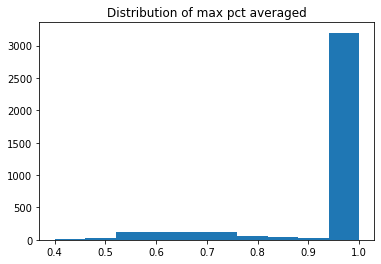

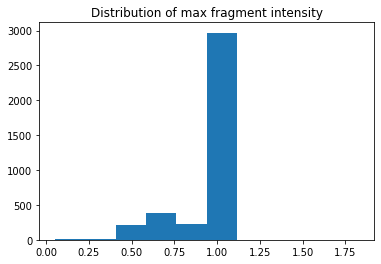

In [19]:
if is_in_notebook():
    from matplotlib import pyplot as plt

    df = con.sql(
        "SELECT peptide_sequence, MAX(pct_averaged) AS max_pct_avg, MAX(fragment_intensity) as max_intensity FROM averaged_annotations GROUP BY peptide_sequence"
    ).to_df()
    plt.hist(df["max_pct_avg"])
    plt.title("Distribution of max pct averaged")
    plt.show()

    plt.hist(df["max_intensity"])
    plt.title("Distribution of max fragment intensity")
    plt.show()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

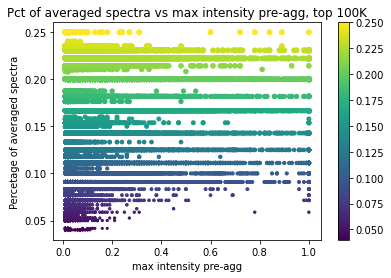

In [20]:
if is_in_notebook():
    from matplotlib import pyplot as plt

    df = con.sql(
        """
        SELECT * from averaged_annotations ORDER BY pct_averaged ASC LIMIT 100000
        """
    ).to_df()
    df
    plt.scatter(
        y=df["pct_averaged"],
        x=df["max_fragment_intensity_prior_to_averaging"],
        c=df["num_spectra"] / df["num_peptide_spec"],
        s=(df["num_spectra"] / df["num_peptide_spec"]) * 100,
    )
    plt.ylabel("Percetage of averaged spectra")
    plt.xlabel("max intensity pre-agg")
    plt.colorbar()
    plt.title("Pct of averaged spectra vs max intensity pre-agg, top 100K")
    # Save the plot to a file
    plt.savefig("peak_aggregation.png")
    plt.show()

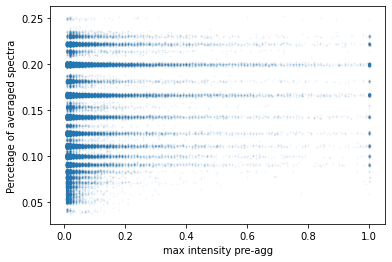

In [21]:
if is_in_notebook():
    import numpy as np

    plt.scatter(
        y=df["pct_averaged"] + np.random.normal(0, 0.001, len(df)),
        x=df["max_fragment_intensity_prior_to_averaging"]
        + np.random.normal(0, 0.001, len(df)),
        s=1,
        alpha=0.05,
    )
    plt.ylabel("Percetage of averaged spectra")
    plt.xlabel("max intensity pre-agg")

In [22]:
logging.info("Creating nested annotations table")

# Iteratively add sequences by the combination of
# precursor_charge, fragmentation, mass_analyzer

first_round = True

precursor_charges = [3, 2, 1, 4, 5, 6, 7]
for pc in precursor_charges:
    for frag in ["HCD", "CID", "ETD"]:
        for ma in ["ITMS", "FTMS"]:
            logging.info(f"Processing {pc}, {frag}, {ma}")
            out = con.sql(
                f"""
                {'EXPLAIN ANALYZE' if first_round else ''}
                {'CREATE OR REPLACE TABLE nested_annotations AS' if first_round else 'INSERT INTO nested_annotations'}
                SELECT
                    peptide_sequence,
                    -- TODO: Add stripped peptide here
                    precursor_charge,
                    LIST (fragment_ion_type),
                    LIST (fragment_no), -- TODO consider filter for this 
                    LIST (fragment_charge),
                    LIST (fragment_intensity),
                    LIST (theoretical_fragment_mz),
                    fragmentation,
                    mass_analyzer,
                    MEAN(retention_time) as retention_time,
                    MEAN(indexed_retention_time) as indexed_retention_time,
                    orig_collision_energy,
                    MEAN(aligned_collision_energy) as aligned_collision_energy,
                FROM averaged_annotations
                WHERE precursor_charge = {pc}
                AND fragmentation = '{frag}'
                AND mass_analyzer = '{ma}'
                -- pretty liberal filter, I am assuming that peaks that were not averaged 
                -- are low abundance ... BUT who knows ...
                AND pct_averaged > 0.1 
                GROUP BY peptide_sequence, precursor_charge, fragmentation, mass_analyzer, orig_collision_energy
                """
            )
            if first_round:
                logging.info(out["explain_value"].to_df().iloc[0, 0])
            first_round = False

logging.info("Created nested annotations table")

02:11:32 Creating nested annotations table
02:11:32 Processing 3, HCD, ITMS
02:11:32 ┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││    Query Profiling Information    ││
│└───────────────────────────────────┘│
└─────────────────────────────────────┘
                 EXPLAIN ANALYZE                 CREATE OR REPLACE TABLE nested_annotations AS                 SELECT                     peptide_sequence,                     -- TODO: Add stripped peptide here                     precursor_charge,                     LIST (fragment_ion_type),                     LIST (fragment_no), -- TODO consider filter for this                      LIST (fragment_charge),                     LIST (fragment_intensity),                     LIST (theoretical_fragment_mz),                     fragmentation,                     mass_analyzer,                     MEAN(retention_time) as retention_time,                     MEAN(indexed_retention_time) as indexed_retention_tim

In [23]:
con.sql("SELECT * FROM nested_annotations LIMIT 5").to_df()

,peptide_sequence,precursor_charge,list(fragment_ion_type),list(fragment_no),list(fragment_charge),list(fragment_intensity),list(theoretical_fragment_mz),fragmentation,mass_analyzer,retention_time,indexed_retention_time,orig_collision_energy,aligned_collision_energy
0,VSKASLDTGQMAFTLAQLESLEIC[UNIMOD:4]LK,3,"[b, y, b, y, b, y, y, b, b, y, y, y, y, b, y, ...","[23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 1, 2,...","[2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 1, 2, 1, 1, 1, ...","[0.02, 0.045714285714285714, 0.044285714285714...","[1217.6303409670002, 1270.142756802, 812.08931...",HCD,ITMS,58.745815,115.398350,28.0,30.365828
1,LEC[UNIMOD:4]SGAISAHC[UNIMOD:4]NLC[UNIMOD:4]LP...,3,"[y, b, y, b, y, b, y, b, y, b, y, y, y, b, y, ...","[23, 23, 23, 23, 24, 24, 24, 25, 25, 26, 26, 1...","[3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 1, 1, 1, 2, ...","[0.016, 0.006, 0.022000000000000002, 0.02, 0.0...","[810.3776430236667, 823.6996161336666, 1215.06...",HCD,ITMS,40.240596,67.921071,28.0,30.365828
2,IGLAVDMDEIEKYQEVEEDQDPSC[UNIMOD:4]PR,3,"[b, y, y, b, b, y, y, b, y, y, y, y, b, y, y, ...","[23, 23, 24, 24, 25, 25, 1, 2, 2, 2, 3, 3, 3, ...","[3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 1, 2, 1, 2, 3, ...","[0.02, 0.02, 0.02, 0.03, 0.03, 0.02, 0.05, 0.0...","[878.7302964670001, 928.0654606903335, 965.760...",HCD,ITMS,45.589000,81.643020,28.0,30.365828
3,NDLTIQLQAEQENLM[UNIMOD:35]DAEERLTWM[UNIMOD:35]MK,3,"[y, y, b, b, y, y, b, b, y, b, b, b, y, y, b, ...","[23, 24, 24, 25, 25, 1, 2, 2, 2, 3, 3, 3, 3, 3...","[3, 3, 3, 3, 3, 1, 1, 2, 1, 3, 1, 2, 1, 2, 1, ...","[0.03142857142857143, 0.015714285714285715, 0....","[947.4469610903335, 985.1416490903335, 969.116...",HCD,ITMS,54.270470,103.916335,28.0,30.365828
4,PMAVAEANQYTFHLEATENPGTLIKDIR,3,"[y, y, b, b, y, y, y, y, y, b, y, b, y, y, y, ...","[23, 23, 23, 25, 25, 26, 26, 27, 1, 2, 2, 2, 3...","[2, 3, 3, 3, 3, 2, 3, 3, 1, 1, 1, 2, 1, 2, 3, ...","[0.006, 0.008, 0.008, 0.005, 0.008, 0.003, 0.0...","[1330.6693748020002, 887.4486753570001, 829.39...",HCD,ITMS,46.905411,85.020425,28.0,30.365828


In [24]:
logging.info("Dropping averaged_annotations")
con.execute("DROP TABLE averaged_annotations")
logging.info("Dropped averaged_annotations")

02:11:32 Dropping averaged_annotations
02:11:32 Dropped averaged_annotations


In [25]:
"""
fragmentation	mass_analyzer	count_star()
0	HCD	FTMS	22066
1	CID	ITMS	4750
2	HCD	ITMS	4473
"""

counts = con.sql(
    "SELECT fragmentation, mass_analyzer, COUNT(*) FROM nested_annotations GROUP BY fragmentation, mass_analyzer"
).to_df()

logging.info("Counts per fragmentation and mass analyzer")
logging.info(counts)

02:11:32 Counts per fragmentation and mass analyzer
02:11:32   fragmentation mass_analyzer  count_star()
0           HCD          ITMS          4474
1           HCD          FTMS         22068
2           CID          ITMS          4751


In [26]:
# Export nested_annotations to parquet in bundles of ~20k
# Duckdb stores data in vectors of 2048 by default.
vectors_per_chunk = int(20_000 / 2048) + 1
index = 0

handle = con.execute("select * from nested_annotations")

while len(batch := handle.fetch_df_chunk(vectors_per_chunk)):
    logging.info(f"Writing batch {index}")
    batch.to_parquet(f"nested_annotations_{index}.parquet")
    if index == 0:
        print(batch.head(10))
    index += 1

02:11:33 Writing batch 0
02:11:33 Writing batch 1


                                    peptide_sequence  precursor_charge  \
0               VSKASLDTGQMAFTLAQLESLEIC[UNIMOD:4]LK                 3   
1  LEC[UNIMOD:4]SGAISAHC[UNIMOD:4]NLC[UNIMOD:4]LP...                 3   
2               IGLAVDMDEIEKYQEVEEDQDPSC[UNIMOD:4]PR                 3   
3   NDLTIQLQAEQENLM[UNIMOD:35]DAEERLTWM[UNIMOD:35]MK                 3   
4                       PMAVAEANQYTFHLEATENPGTLIKDIR                 3   
5                          GFLAQTPPLEFPVHQYQPGDHVLIK                 3   
6  VEAEDVGVYYC[UNIMOD:4]M[UNIMOD:35]QGLQTPQTFGQGT...                 3   
7                           LQAEVEDLTIDLEKANAAAAALDK                 3   
8           PTPMAQAEAQAHLQSSFPVLSPAFLSPM[UNIMOD:35]K                 3   
9            SVVPESDTSERSSM[UNIMOD:35]TSGSSESDIPQENK                 3   

                             list(fragment_ion_type)  \
0  [b, y, b, y, b, y, y, b, b, y, y, y, y, b, y, ...   
1  [y, b, y, b, y, b, y, b, y, b, y, y, y, b, y, ...   
2  [b, y, y, b, b

In [27]:
con.sql("SHOW tables;")

┌────────────────────┐
│        name        │
│      varchar       │
├────────────────────┤
│ filtered_meta      │
│ middle_tmp         │
│ nested_annotations │
│ rt_qc              │
│ tmp                │
└────────────────────┘

In [28]:
# con.sql("PRAGMA storage_info('averaged_annotations');").to_df()["count"].sum() / 1e6
# # 50.8
# con.sql("PRAGMA storage_info('filtered_meta');").to_df()["count"].sum() / 1e6
# # 4.2
# con.sql("PRAGMA storage_info('joint_local_annotations');").to_df()["count"].sum() / 1e6
# # 106.75
# con.sql("PRAGMA storage_info('local_annotations');").to_df()["count"].sum() / 1e6
# # 100.4
# con.sql("PRAGMA storage_info('nested_annotations');").to_df()["count"].sum() / 1e6
# # 9.3
# con.sql("PRAGMA storage_info('rt_qc');").to_df()["count"].sum() / 1e6
# # 0.06
# con.sql("PRAGMA storage_info('middle_tmp');").to_df()["count"].sum() / 1e6
# # 0.24

In [29]:
# TODO add splitting
# TODO add split set
con.close()